<a href="https://colab.research.google.com/github/KimMinoo/PM2.5-Prediction/blob/main/Attention_mechanism1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision 
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
# test_aws = pd.read_csv('/content/test_aws')
# test_pm = pd.read_csv('/content/test_pm')
# train_aws = pd.read_csv('/content/train_aws')
# train_pm = pd.read_csv('/content/train_pm')

# train_df = pd.merge(test_aws, test_pm)
# test_df = pd.merge(train_aws, train_pm)
train_df = pd.read_csv('/content/drive/Shareddrives/미세먼지_예측_대회/TRAIN_ALL/TRAIN_4_real_final.csv')
# test_df = pd.read_csv('/content/공주_val.csv')

del train_df['일시']
# del test_df['일시']
del train_df['강수량(mm)']
# del test_df['강수량(mm)']

# del train_df['풍향(deg)']
# del test_df['풍향(deg)']
# del train_df['풍속(m/s)']
# del test_df['풍속(m/s)']

train_df=train_df.interpolate()
# test_df=test_df.interpolate()

train_df = train_df.dropna()
# test_df = train_df.dropna()

# train_size = int(len(train_df)*0.9)
# train_set = train_df[0:train_size]  
# val_set = train_df[train_size:]
# test_set = test_df

train_size = 35063*27
train_set = train_df[0:train_size]
val_set = train_df[train_size:]


# train_set = train_set.transpose()
# val_set = val_set.transpose()
# test_set = test_set.transpose()

# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 48
batch = 128

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용


# train_df


In [ ]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

k=[]
for j in range(30):
    for i in range(seq_length):
      k.append(35063*(j+1)-seq_length+i+1)

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length-72):
        _x = time_series[i:i+seq_length, :].transpose()
        _y = time_series[i+seq_length:i+seq_length+72, -1].reshape(-1,1)
        if i in k:
          continue
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

# # 데이터셋 생성 함수
# def AWS_build_dataset(time_series, seq_length):
#     dataX = []
#     dataY = []
#     for i in range(0, len(time_series)-seq_length):
#         _x = time_series[i:i+seq_length, :-1]
#         _y = time_series[i+seq_length, :-1]
#         dataX.append(_x)
#         dataY.append(_y)
#     return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
valX, valY = build_dataset(np.array(val_set), seq_length)
# testX, testY = build_dataset(np.array(test_set), seq_length)

trainX_tensor = torch.FloatTensor(trainX).cuda()
trainY_tensor = torch.FloatTensor(trainY).cuda()

valX_tensor = torch.FloatTensor(valX).cuda()
valY_tensor = torch.FloatTensor(valY).cuda()

# testX_tensor = torch.FloatTensor(testX).cuda()
# testY_tensor = torch.FloatTensor(testY).cuda()

train_dataset = TensorDataset(trainX_tensor, trainY_tensor)
val_dataset = TensorDataset(valX_tensor, valY_tensor)
# test_dataset = TensorDataset(testX_tensor, testY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
train_dataloader = DataLoader(train_dataset,batch_size=batch, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)



In [ ]:
# 설정값
input_dim = 48
encoder_hidden_dim = 72
decoder_hidden_dim = 36
output_dim = 1
learning_rate = 0.01
nb_epochs = 1500

class encoder(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, encoder_hidden_dim, decoder_hidden_dim):
        super(encoder, self).__init__()
        self.rnn = nn.GRU(input_dim, encoder_hidden_dim,dropout = 0.15, batch_first=True)
        self.fc = nn.Linear(encoder_hidden_dim, decoder_hidden_dim)

    # 예측을 위한 함수
    def forward(self, x):
        outputs, hidden = self.rnn(x)
        hidden = torch.tanh(self.fc(hidden))

        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attention = nn.Linear(encoder_hidden_dim + decoder_hidden_dim, decoder_hidden_dim)
        self.v = nn.Linear(decoder_hidden_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        # hidden = [배치 사이즈, 디코더 히든 차원]
        # encoder_outputs = [단어 개수, 배치 사이즈, 인코더 히든 차원*2]

        batch_size = encoder_outputs.shape[0] # 배치 사이즈
        src_len = encoder_outputs.shape[1] # 단어 개수
        
        hidden = hidden.reshape(batch_size, 1, -1)
        hidden = hidden.repeat(1, src_len, 1)

        # hidden = [배치 사이즈, 단어 개수, 디코더 히든 차원]
        # encoder_outputs = [ 배치 사이즈, 단어 개수,인코더 히든 차원]
        
        
        # 바다나우 어텐션        
        energy = torch.tanh(self.attention(torch.cat([hidden, encoder_outputs], dim = 2)))

        # softmax 정규화      
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

class decoder(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, decoder_input_dim, decoder_output_dim, encoder_hidden_dim, decoder_hidden_dim, attention):
        super(decoder, self).__init__()
        self.decoder_output_dim = decoder_output_dim
        self.attention = attention

        self.rnn = nn.GRU(decoder_input_dim+ encoder_hidden_dim, decoder_hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(encoder_hidden_dim + decoder_hidden_dim + decoder_input_dim, decoder_output_dim)

    # 예측을 위한 함수
    def forward(self, input, hidden, encoder_outputs):
        
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)

        
        rnn_input = torch.cat([input, weighted], dim = 2)

        output, hidden = self.rnn(rnn_input, hidden)

        assert (output == hidden.permute(1,0,2)).all()
        
        input = input.squeeze(1)
        output = output.squeeze(1)
        weighted = weighted.squeeze(1)
        
        prediction = self.fc_out(torch.cat([output, weighted, input], dim = 1))
        prediction = prediction.reshape(encoder_outputs.shape[0], 1, self.decoder_output_dim)
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, encoder_input, decoder_input):
        # src: [src len, batch size]
        # trg: [trg len, batch size]
        
        batch_size = encoder_input.shape[0]
        dec_len = decoder_input.shape[1]

        outputs = torch.zeros(encoder_input.shape[0], encoder_input.shape[1], decoder_input.shape[1]).to(self.device)

        encoder_outputs, hidden = self.encoder(encoder_input)

        outputs = torch.empty(batch_size, 0, decoder_input.shape[2]).cuda()
        # input = encoder_input[:,-1,[-1]].unsqueeze(1).to(self.device)
        
        input = torch.zeros(batch_size, 1, decoder_input.shape[2]).to(self.device)
        for i in range(0,dec_len): # <eos> 제외하고 trg_len-1 만큼 반복
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            outputs = torch.cat([outputs,output],dim=1)

            # teacher forcing을 사용할지, 말지 결정
            if self.teacher_forcing_ratio != 0:
                teacher_force = random.random() < self.teacher_forcing_ratio
                input = decoder_input[:,i,[-1]].unsqueeze(1) if teacher_force else output
            elif self.teacher_forcing_ratio == 0:
                input = output

        return outputs

In [ ]:
import time

def train():
    start_time = time.time()
    model.train()

    total = 0
    running_loss = 0.0

    for i, batch in enumerate(train_dataloader):
        x, y = batch
            
        output = model(x,y)
        optimizer.zero_grad()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
            
        total += 1
        running_loss += loss.item()

    return running_loss/total

def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.eval()

    total = 0
    running_loss = 0.0

    for i, batch in enumerate(val_dataloader):
        x, y = batch

        with torch.no_grad(): 
          output = model(x,y)
          loss = criterion(output, y)
            
        total += 1
        running_loss += loss.item()

    return running_loss/total

# def test():
#     start_time = time.time()
#     print(f'[Epoch: {epoch + 1} - Training]')
#     model.eval()

#     total = 0
#     running_loss = 0.0

#     for i, batch in enumerate(test_dataloader):
#         x, y = batch

#         with torch.no_grad(): 
#           output = model(x,y)
#           loss = criterion(output, y)
            
#         total += 1
#         running_loss += loss.item()

#     return running_loss/total

In [ ]:
import time

# def adjust_learning_rate(optimizer, epoch):
#   lr = learning_rate
#   if epoch % 10 == 0:
#     lr /= 5
#   for param_group in optimizer.param_groups:
#     param_group['lr'] = lr

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch: 1 - Training]
train loss: 0.0007560173388095743 	val_loss: 0.0009337504537475847
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.0007569072292342066 	val_loss: 0.0009395998443834265
[Epoch: 3 - Training]
train loss: 0.0007581472063210736 	val_loss: 0.0009348328309121227
[Epoch: 4 - Training]
train loss: 0.0007576696098937868 	val_loss: 0.0009384514736000977
[Epoch: 5 - Training]
train loss: 0.0007573723802842721 	val_loss: 0.0009464987000150936
[Epoch: 6 - Training]
train loss: 0.0007575798065470343 	val_loss: 0.0009432197885716295
[Epoch: 7 - Training]
train loss: 0.0007555963173872787 	val_loss: 0.0009426941371468895
[Epoch: 8 - Training]
train loss: 0.0007575083737942272 	val_loss: 0.000933193854316636
[Info] best validation accuracy!
[Epoch: 9 - Training]
train loss: 0.0007573512455200387 	val_loss: 0.0009345586256064807
[Epoch: 10 - Training]
train loss: 0.0007583115573777939 	val_loss: 0.0009384351671010003
[Epoch: 11 - Training]
train loss: 0.0007565

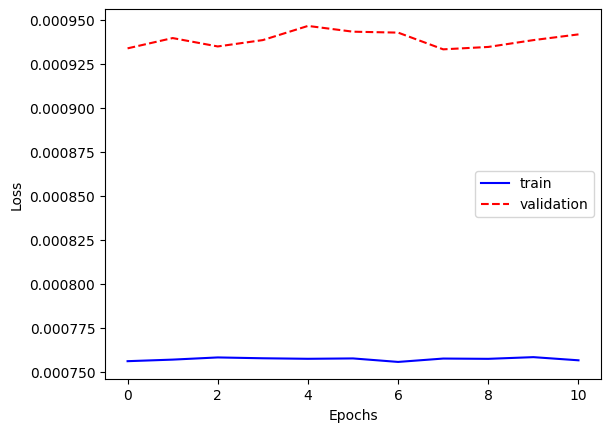

In [ ]:
learning_rate = 0.0091
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = encoder(input_dim, encoder_hidden_dim, decoder_hidden_dim).cuda()
attention = Attention(encoder_hidden_dim, decoder_hidden_dim).cuda()
dec = decoder(1, 1,  encoder_hidden_dim, decoder_hidden_dim, attention).cuda()
model = Seq2Seq(enc, dec, device, 0.5).to(device)
model.load_state_dict(torch.load("/content/drive/Shareddrives/미세먼지_예측_대회/김민우/pretrained2.pth"))
model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 11
best_epoch = 0
verbose = 1
patience = 11
best_val_loss = 5

history = []

for epoch in range(num_epochs):
    # adjust_learning_rate(optimizer, epoch)
    train_loss = train()
    val_loss = validate()
    history.append((train_loss, val_loss))

    if epoch % verbose == 0:
        print('train loss:',train_loss,'\tval_loss:',val_loss)
            
    #     # patience번째 마다 early stopping 여부 확인
    # if (epoch % patience == 0) & (epoch != 0):
    #     if history[epoch][0] < history[epoch-10][0]:
    #             print('\n Early Stopping')
    #             break

    if val_loss < best_val_loss:
        print("[Info] best validation accuracy!")
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "best_checkpoint_epoch.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# test_loss = test()
# print(f"Test loss: {test_loss: .8f}")

In [ ]:
!cp /content/drive/MyDrive/ai_study/pm2.5_prediction.pth /content/drive/Shareddrives/미세먼지_예측_대회/김민우/kmw_prediction.pth

In [ ]:
import os
answer = pd.read_csv("/content/drive/MyDrive/ai/answer_sample.csv")
folder = os.listdir("/content/drive/Shareddrives/미세먼지_예측_대회/TEST")
model2 = Seq2Seq(enc, dec, device, 0).to(device)
model2.load_state_dict(torch.load("/content/drive/MyDrive/ai/kmw_prediction.pth"))

measurement = answer['측정소'].drop_duplicates()
ans_idx = 0

dataX=[]
for name in measurement:
    df = pd.read_csv("/content/drive/Shareddrives/미세먼지_예측_대회/TEST/"+name+".csv").drop(["일시"],axis=1)
    test_x = np.array(df)
    for idx in range(0,df.shape[0],48):
        sliced_x = test_x[idx:idx+48].transpose()
        dataX.append(sliced_x)
        
final_data = np.array(dataX)
x = torch.FloatTensor(final_data).cuda()
y_pred = np.array(model2(x, x).unsqueeze(2).cpu().detach())

for i in range(y_pred.shape[0]):
  for j in range(y_pred.shape[1]):
      answer['PM2.5'][i*72+j] = y_pred[i, j]
answer.to_csv("/content/drive/MyDrive/answer_ANN.csv",encoding='utf-8')









In [ ]:
out = []

for i, batch in enumerate(val_dataloader):
    x, y = batch
    output = model(x,y)
    out.append(output.data.cpu().numpy()[1,:])
    break

label_y = valY_tensor.cpu().numpy()[1,:]
len_72 = []
for i in range(72) :
  len_72.append(i+1)
plt.figure(figsize=(10, 6))
plt.scatter(len_72, label_y, label='Actual Data')
plt.scatter(len_72, out, label='Predicted Data')
plt.legend()
plt.show()